In [1]:
import os
import sys
import time
import datetime

import random
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential, Model
from keras.layers import Activation, Dense, Flatten, BatchNormalization, \
Conv2D, MaxPool2D, Dropout, Input, LeakyReLU, AveragePooling2D

from keras.optimizers import Adam, SGD , RMSprop
from keras.losses import mae, sparse_categorical_crossentropy, binary_crossentropy

from keras.preprocessing.image import ImageDataGenerator
from keras.applications.resnet import preprocess_input

from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping

from keras.applications.vgg16 import VGG16
from keras.applications.xception import Xception
from keras.applications.resnet import ResNet50
from keras.applications.inception_v3 import InceptionV3
from keras.applications.inception_resnet_v2 import InceptionResNetV2
from keras.applications.densenet import DenseNet201
from keras.applications.nasnet import NASNetMobile, NASNetLarge

import warnings
warnings.filterwarnings('ignore')

In [2]:
def timestamp(x):
    
    if x==1:
        return 'Timestamp: {:%Y-%m-%d %H:%M:%S}'.format(datetime.datetime.now())
    if x==2:    
        return 'Timestamp: {:%Y-%b-%d %H:%M:%S}'.format(datetime.datetime.now())
    if x==3:  
        return 'Date now: %s' % datetime.datetime.now()
    if x==4:  
        return 'Date today: %s' % datetime.date.today()  

In [3]:
dataset_path = os.path.join(os.getcwd(), 'Dataset')

train_dir = os.path.join(dataset_path, 'train')
test_dir = os.path.join(dataset_path, 'test')

In [4]:
def plot_img(file, dirs = train_dir):
  
    img_path = os.path.join(dirs, file)
    img = plt.imread(img_path)
    #img = img.numpy().transpose((1, 2, 0))
    plt.imshow(img, aspect = None)

    plt.xticks([])
    plt.yticks([])

def img_path(dir = train_dir, count = 5):

    files = random.sample(os.listdir(dir), count)
    ncol, nrow = 5, 3
  
    FIGSIZE = (20, 15)
    plt.figure(figsize=FIGSIZE)

    for i, file in enumerate(files):
        plt.subplot(nrow, ncol, i+1)
        path = os.path.join(dir, file)
        plot_img(file, dir)
    plt.tight_layout()
    plt.show()

def label_path(dir = train_dir, count = 5):
    
    labels = os.listdir(dir)
    
    for label in labels:
        print(label)
        label_path = os.path.join(dir, label)
        img_path(dir = label_path, count = 5)

Viral Pneumonia


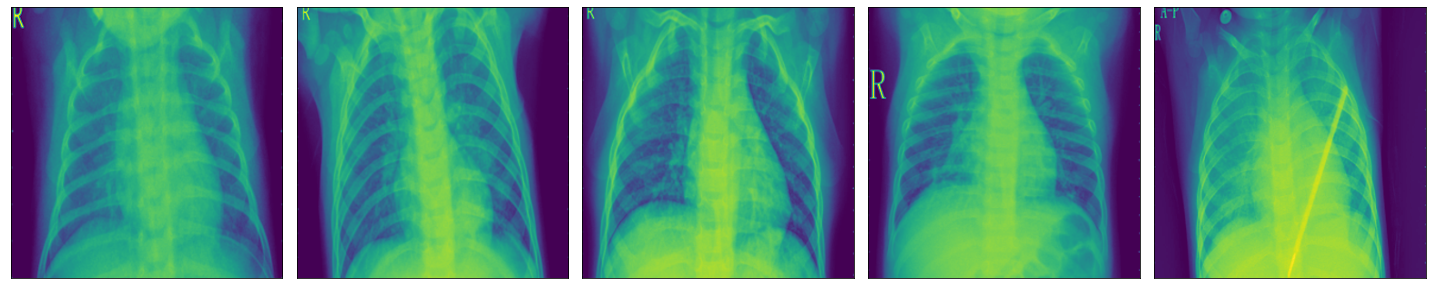

COVID


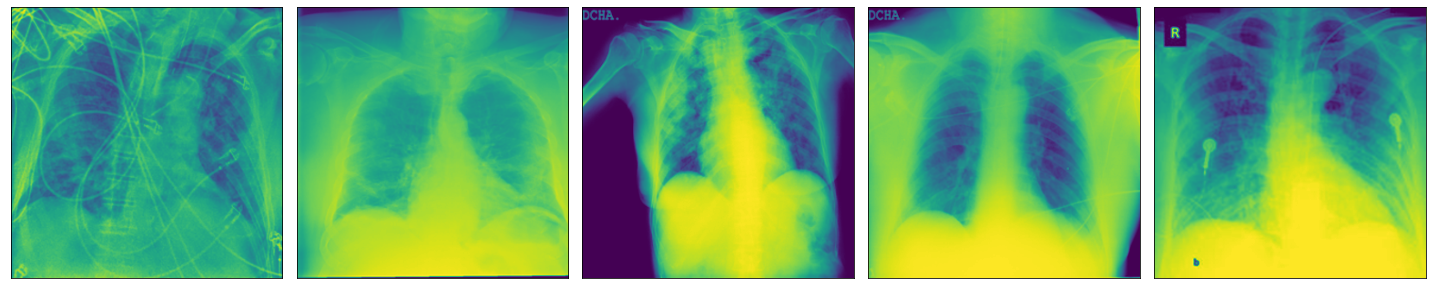

Normal


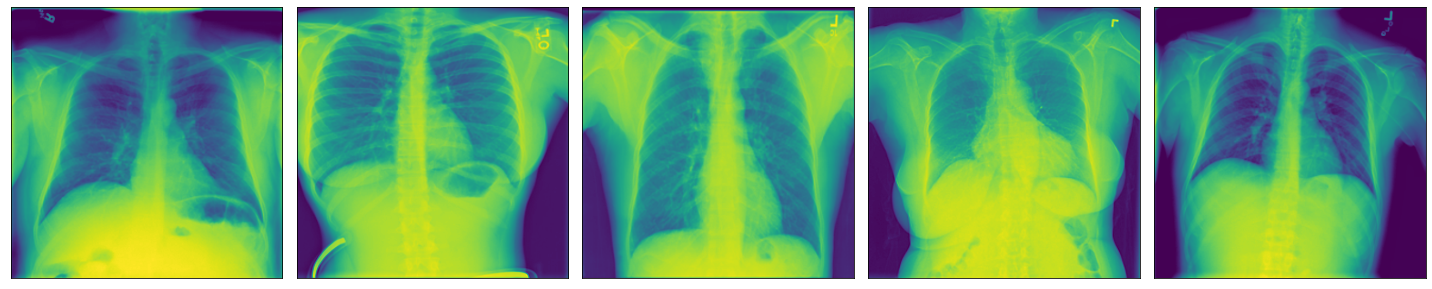

In [6]:
label_path(train_dir, 5)

In [ ]:
def create_data(train_path = None, test_path = None, batch_size = 64, target_size = (300, 300), class_mode = 'categorical'):

    print('Creating and preprocessing data batches for training and testing!')
    print('-' * 65)

    TRAIN_BATCH_SIZE, TEST_BATCH_SIZE = batch_size, batch_size
    RESCALE = 1.0/255

    train_shuffle = True
    val_shuffle = True
    test_shuffle = False

    train_generator = ImageDataGenerator(
        horizontal_flip=True,
        rotation_range=30,
        rescale=RESCALE,
        validation_split=0.25
    )

    test_generator = ImageDataGenerator(preprocessing_function = preprocess_input)

    train_data = train_generator.flow_from_directory(
        train_path,
        target_size = target_size,
        class_mode = class_mode,
        batch_size = TRAIN_BATCH_SIZE,
        shuffle = train_shuffle,
        seed = 42,
        subset = 'training'
    )

    validation_data = train_generator.flow_from_directory(
        train_path,
        target_size = target_size,
        class_mode = class_mode,
        batch_size = TRAIN_BATCH_SIZE,
        shuffle = val_shuffle,
        seed = 42,
        subset = 'validation'
    )

    test_data = test_generator.flow_from_directory(
        test_path,
        target_size = target_size,
        batch_size = TEST_BATCH_SIZE,
        shuffle = test_shuffle
    )

    train_step = train_data.n//train_data.batch_size
    val_step = validation_data.n//validation_data.batch_size

    return train_data, validation_data, test_data, train_step, val_step

In [ ]:
def create_model(model_name, input_shape = (256, 256, 3), num_class = 3):
    
    input = Input(input_shape)

    if model_name == 'ResNet50':
        base_model = ResNet50(include_top = False, weights = 'imagenet', input_shape = input_shape)
    elif model_name == 'VGG16':
        base_model = VGG16(include_top = False, weights = 'imagenet', input_shape = input_shape)
    elif model_name == 'NASNetMobile':
        base_model = NASNetMobile(include_top = False, weights = 'imagenet', input_shape = input_shape)

    for layer in base_model.layers:
        layer.trainable = False

    head_model = base_model.output
  # head_model = AveragePooling2D(pool_size=(4, 4))(head_model)
    head_model = Flatten(name="flatten")(head_model)
    head_model = Dense(64, activation="relu")(head_model)
    head_model = LeakyReLU(alpha=0.4)(head_model)
  # head_model = Dropout(0.2)(head_model)
    
    if num_class > 1:
        head_model = Dense(num_class, activation="softmax")(head_model)
    else:
        head_model = Dense(1, activation="sigmoid")(head_model)

    model = Model(base_model.input, head_model)

    model.summary()

    return model

In [ ]:
def create_baseline(input_shape = (256, 256, 3), num_class = 3):
    
    model = Sequential()
    
    model.add(Conv2D(16, (3, 3), activation='relu', padding="same", input_shape=input_shape))
    model.add(Conv2D(16, (3, 3), padding="same", activation='relu'))
    model.add(MaxPool2D(pool_size=(2, 2)))
    model.add(BatchNormalization())
    
    model.add(Conv2D(32, (3, 3), activation='relu', padding="same"))
    model.add(Conv2D(32, (3, 3), padding="same", activation='relu'))
    model.add(MaxPool2D(pool_size=(2, 2)))
    model.add(BatchNormalization())

    model.add(Conv2D(64, (3, 3), activation='relu', padding="same"))
    model.add(Conv2D(64, (3, 3), padding="same", activation='relu'))
    model.add(MaxPool2D(pool_size=(2, 2)))
    model.add(BatchNormalization())
    
    model.add(Conv2D(128, (3, 3), dilation_rate=(2, 2), activation='relu', padding="same"))
    model.add(Conv2D(128, (3, 3), padding="valid", activation='relu'))
    model.add(MaxPool2D(pool_size=(2, 2)))
    model.add(BatchNormalization())

    model.add(Flatten())
    
    model.add(Dropout(0.5))
    model.add(BatchNormalization())
    
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.5))
    model.add(BatchNormalization())
    
    model.add(Dense(num_class , activation='softmax'))

    print(model.summary())
    
    return model

In [ ]:
batch_size = 64
target_size = (224, 224)

train_data, val_data, test_data, train_step, val_step = create_data(train_path = train_dir, test_path = test_dir, batch_size = batch_size, 
                                                                    target_size=target_size, class_mode='categorical')

Creating and preprocessing data batches for training and testing!
-----------------------------------------------------------------
Found 9093 images belonging to 3 classes.
Found 3030 images belonging to 3 classes.
Found 3030 images belonging to 3 classes.


# Creating and testing a baseline convolutional neural network.

In [ ]:
input_shape = (224, 224, 3)
num_class = 3

print('Loading Base Model')

convnet = create_baseline(input_shape = input_shape, num_class = num_class)

print('Model Loaded at ', timestamp(1))

Loading Base Model
Metal device set to: Apple M1


2022-12-28 17:56:33.107687: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-12-28 17:56:33.107730: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 16)      448       
                                                                 
 conv2d_1 (Conv2D)           (None, 224, 224, 16)      2320      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 16)     0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 112, 112, 16)     64        
 ormalization)                                                   
                                                                 
 conv2d_2 (Conv2D)           (None, 112, 112, 32)      4640      
                                                                 
 conv2d_3 (Conv2D)           (None, 112, 112, 32)      9

In [ ]:
EPOCHS = 10
ILR = 0.001
VERBOSE = 1

optimizer = Adam(learning_rate = ILR)
loss = 'categorical_crossentropy'
metrics = ['accuracy']

print('Compiling Model')
print('-' * 15)

convnet.compile(optimizer = optimizer, loss = loss, metrics = metrics)

Compiling Model
---------------


In [ ]:
print("Starting Training ...\n")

start_time = time.time()

history = convnet.fit(
    train_data,
    steps_per_epoch=train_step,
    epochs = EPOCHS,
    verbose = VERBOSE,
    validation_data = val_data,
    validation_steps = val_step
)

elapsed_time = time.time() - start_time
elapsed_time = time.strftime("%H:%M:%S", time.gmtime(elapsed_time))

print("\nElapsed Time: " + elapsed_time)
print("Completed Model Trainning", timestamp(1))

Starting Training ...

Epoch 1/10


2022-12-28 17:59:38.671622: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-12-28 17:59:39.346578: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


142/142 [==============================] - ETA: 0s - loss: 0.6822 - accuracy: 0.7584

2022-12-28 18:01:33.818511: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


142/142 [==============================] - 144s 993ms/step - loss: 0.6822 - accuracy: 0.7584 - val_loss: 2.1031 - val_accuracy: 0.2394
Epoch 2/10
142/142 [==============================] - 147s 1s/step - loss: 0.3846 - accuracy: 0.8591 - val_loss: 0.9533 - val_accuracy: 0.5824
Epoch 3/10
142/142 [==============================] - 154s 1s/step - loss: 0.3831 - accuracy: 0.8545 - val_loss: 4.2318 - val_accuracy: 0.2646
Epoch 4/10
142/142 [==============================] - 153s 1s/step - loss: 0.3088 - accuracy: 0.8875 - val_loss: 0.9226 - val_accuracy: 0.6240
Epoch 5/10
142/142 [==============================] - 147s 1s/step - loss: 0.2838 - accuracy: 0.8919 - val_loss: 0.3157 - val_accuracy: 0.8816
Epoch 6/10
142/142 [==============================] - 150s 1s/step - loss: 0.2454 - accuracy: 0.9092 - val_loss: 0.5694 - val_accuracy: 0.7733
Epoch 7/10
142/142 [==============================] - 153s 1s/step - loss: 0.2081 - accuracy: 0.9252 - val_loss: 0.4538 - val_accuracy: 0.8255
Epoch 8

In [ ]:
def performance_plot(history = None, name = 'Custom Model'):
  
    legends = ['training', 'validation']
    plt.figure(figsize=(20, 5))

    y1 = history.history['accuracy']
    y2 = history.history['val_accuracy']
  
    plt.subplot(121)
    plt.plot(y1)
    plt.plot(y2)

    plt.title(name + '\n' + timestamp(1), fontsize=18)
    plt.xlabel('Epochs', fontsize=15)
    plt.ylabel('Accuracy', fontsize=15)
    plt.legend(legends, loc='upper left')
    plt.grid()

    y1 = history.history['loss']
    y2 = history.history['val_loss']

    plt.subplot(122)
    plt.plot(y1)
    plt.plot(y2)

    plt.title(name + '\n' + timestamp(1), fontsize=18)
    plt.xlabel('Epochs', fontsize=15)
    plt.ylabel('Loss', fontsize=15)
    plt.legend(legends, loc='upper left')
    plt.grid()

    #plt.savefig('plot.png')

    plt.show()

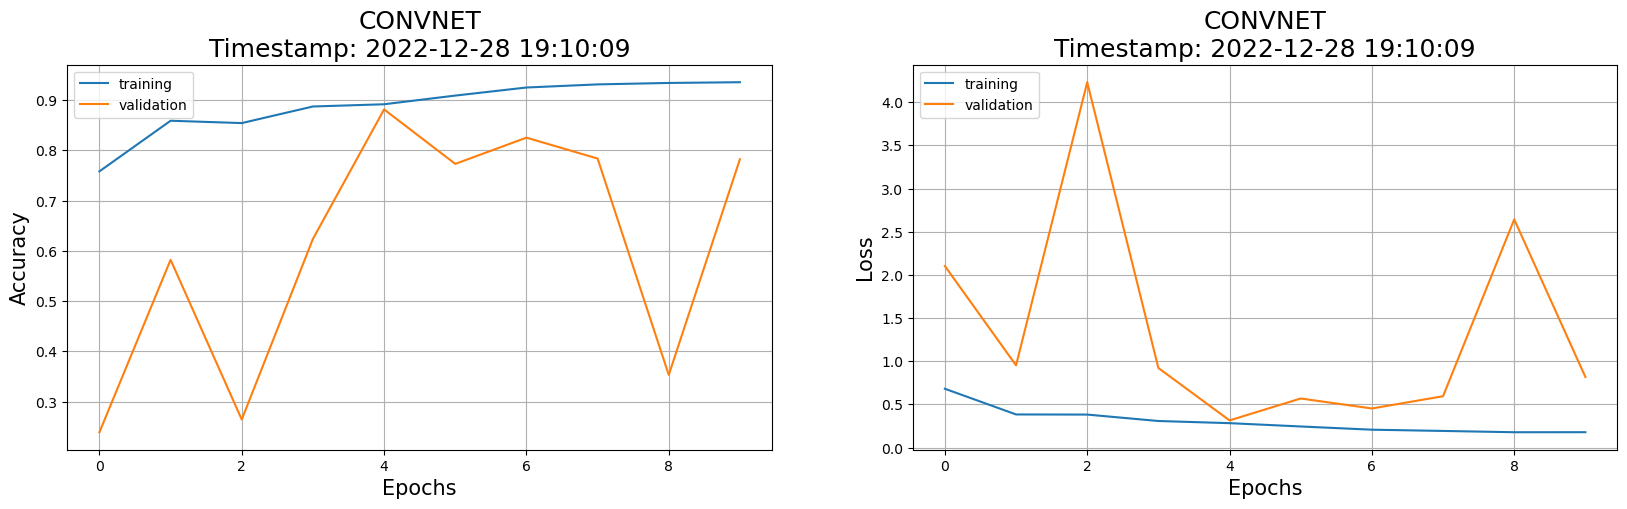

In [ ]:
performance_plot(history = history, name = 'CONVNET')

In [ ]:
loss, accuracy = convnet.evaluate(test_data)

print(f'Final Loss: {loss:.2f} Final Accuracy: {accuracy:.2f}')

48/48 [==============================] - 13s 264ms/step - loss: 6165.8433 - accuracy: 0.2789
Final Loss: 6165.84 Final Accuracy: 0.28


# Transfer Learning

In [ ]:
input_shape = (224, 224, 3)
num_class = 3
model_name = 'VGG16'

print('Loading Base Model')

vggnet = create_model(model_name = model_name, input_shape = input_shape, num_class = num_class)

print('Model Loaded at ', timestamp(1))

Loading Base Model
Metal device set to: Apple M1


2022-12-28 19:12:27.378671: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-12-28 19:12:27.378706: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [ ]:
EPOCHS = 10
ILR = 0.001
VERBOSE = 1

optimizer = Adam(learning_rate = ILR)
loss = 'categorical_crossentropy'
metrics = ['accuracy']

print('Compiling Model')
print('-' * 15)

vggnet.compile(optimizer = optimizer, loss = loss, metrics = metrics)

Compiling Model
---------------


In [ ]:
loss0, accuracy0 = vggnet.evaluate(val_data, verbose = 0)

print(f'Initial Loss: {loss0:.2f} Initial Accuracy: {accuracy0:.2f}')

2022-12-28 19:12:39.083495: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-12-28 19:12:39.249031: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Initial Loss: 1.35 Initial Accuracy: 0.11


In [ ]:
dir_name = 'Model Checkpoint'
file_path = os.path.join(os.getcwd(), dir_name)

if not os.path.exists(file_path):
    print('Directory does not exist. Making it now!')
    os.mkdir(file_path)

In [ ]:
def scheduler(epoch, lr = ILR):
    
    if epoch % 3 == 0:
        return lr * 0.9
    else:
        return lr
    
def set_callbacks(verbose = 0):
    
    model_checkpoint = ModelCheckpoint(filepath = file_path,
                                       monitor = 'val_accuracy',
                                       verbose = 0,
                                       save_best_only = True)
    
    early_stopping = EarlyStopping(monitor = 'val_loss',
                                   patience = 2,
                                   verbose = verbose,
                                   restore_best_weights = True)
    
    learn_scheduler = LearningRateScheduler(scheduler,
                                            verbose = verbose)
    
    callbacks = [model_checkpoint, learn_scheduler, early_stopping]
    
    print('Setting Callbacks...')
    
    return callbacks

In [ ]:
callbacks = set_callbacks(verbose = 1)

print("Starting Training ...\n")

start_time = time.time()

vhistory = vggnet.fit(
    train_data,
    steps_per_epoch=train_step,
    epochs = EPOCHS,
    verbose = VERBOSE,
    callbacks = callbacks,
    validation_data = val_data,
    validation_steps = val_step
)

elapsed_time = time.time() - start_time
elapsed_time = time.strftime("%H:%M:%S", time.gmtime(elapsed_time))

print("\nElapsed Time: " + elapsed_time)
print("Completed Model Trainning", timestamp(1))

Setting Callbacks...
Starting Training ...


Epoch 1: LearningRateScheduler setting learning rate to 0.0009000000427477062.
Epoch 1/10


2022-12-28 19:14:46.048154: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


142/142 [==============================] - ETA: 0s - loss: 0.4729 - accuracy: 0.8403

INFO:tensorflow:Assets written to: /Users/anuragkotiyal/Desktop/Projects/COVID Detection/Model Checkpoint/assets


INFO:tensorflow:Assets written to: /Users/anuragkotiyal/Desktop/Projects/COVID Detection/Model Checkpoint/assets


142/142 [==============================] - 451s 3s/step - loss: 0.4729 - accuracy: 0.8403 - val_loss: 0.2322 - val_accuracy: 0.9152 - lr: 9.0000e-04

Epoch 2: LearningRateScheduler setting learning rate to 0.0009000000427477062.
Epoch 2/10
142/142 [==============================] - ETA: 0s - loss: 0.2434 - accuracy: 0.9071

INFO:tensorflow:Assets written to: /Users/anuragkotiyal/Desktop/Projects/COVID Detection/Model Checkpoint/assets


INFO:tensorflow:Assets written to: /Users/anuragkotiyal/Desktop/Projects/COVID Detection/Model Checkpoint/assets


142/142 [==============================] - 431s 3s/step - loss: 0.2434 - accuracy: 0.9071 - val_loss: 0.2208 - val_accuracy: 0.9189 - lr: 9.0000e-04

Epoch 3: LearningRateScheduler setting learning rate to 0.0009000000427477062.
Epoch 3/10
142/142 [==============================] - ETA: 0s - loss: 0.1860 - accuracy: 0.9301

INFO:tensorflow:Assets written to: /Users/anuragkotiyal/Desktop/Projects/COVID Detection/Model Checkpoint/assets


INFO:tensorflow:Assets written to: /Users/anuragkotiyal/Desktop/Projects/COVID Detection/Model Checkpoint/assets


142/142 [==============================] - 435s 3s/step - loss: 0.1860 - accuracy: 0.9301 - val_loss: 0.1612 - val_accuracy: 0.9455 - lr: 9.0000e-04

Epoch 4: LearningRateScheduler setting learning rate to 0.0008100000384729356.
Epoch 4/10
142/142 [==============================] - ETA: 0s - loss: 0.1513 - accuracy: 0.9452

INFO:tensorflow:Assets written to: /Users/anuragkotiyal/Desktop/Projects/COVID Detection/Model Checkpoint/assets


INFO:tensorflow:Assets written to: /Users/anuragkotiyal/Desktop/Projects/COVID Detection/Model Checkpoint/assets


142/142 [==============================] - 416s 3s/step - loss: 0.1513 - accuracy: 0.9452 - val_loss: 0.1471 - val_accuracy: 0.9461 - lr: 8.1000e-04

Epoch 5: LearningRateScheduler setting learning rate to 0.0008100000559352338.
Epoch 5/10
142/142 [==============================] - ETA: 0s - loss: 0.1457 - accuracy: 0.9456

INFO:tensorflow:Assets written to: /Users/anuragkotiyal/Desktop/Projects/COVID Detection/Model Checkpoint/assets


INFO:tensorflow:Assets written to: /Users/anuragkotiyal/Desktop/Projects/COVID Detection/Model Checkpoint/assets


142/142 [==============================] - 419s 3s/step - loss: 0.1457 - accuracy: 0.9456 - val_loss: 0.1433 - val_accuracy: 0.9465 - lr: 8.1000e-04

Epoch 6: LearningRateScheduler setting learning rate to 0.0008100000559352338.
Epoch 6/10
142/142 [==============================] - 452s 3s/step - loss: 0.1344 - accuracy: 0.9485 - val_loss: 0.1626 - val_accuracy: 0.9408 - lr: 8.1000e-04

Epoch 7: LearningRateScheduler setting learning rate to 0.0007290000503417104.
Epoch 7/10
142/142 [==============================] - 412s 3s/step - loss: 0.1226 - accuracy: 0.9555 - val_loss: 0.1717 - val_accuracy: 0.9342 - lr: 7.2900e-04
Epoch 7: early stopping

Elapsed Time: 00:50:16
Completed Model Trainning Timestamp: 2022-12-28 20:05:01


In [ ]:
loss, accuracy = vggnet.evaluate(test_data, verbose = 0)

print(f'Final Loss: {loss:.2f} Final Accuracy: {accuracy:.2f}')

Final Loss: 27.50 Final Accuracy: 0.67


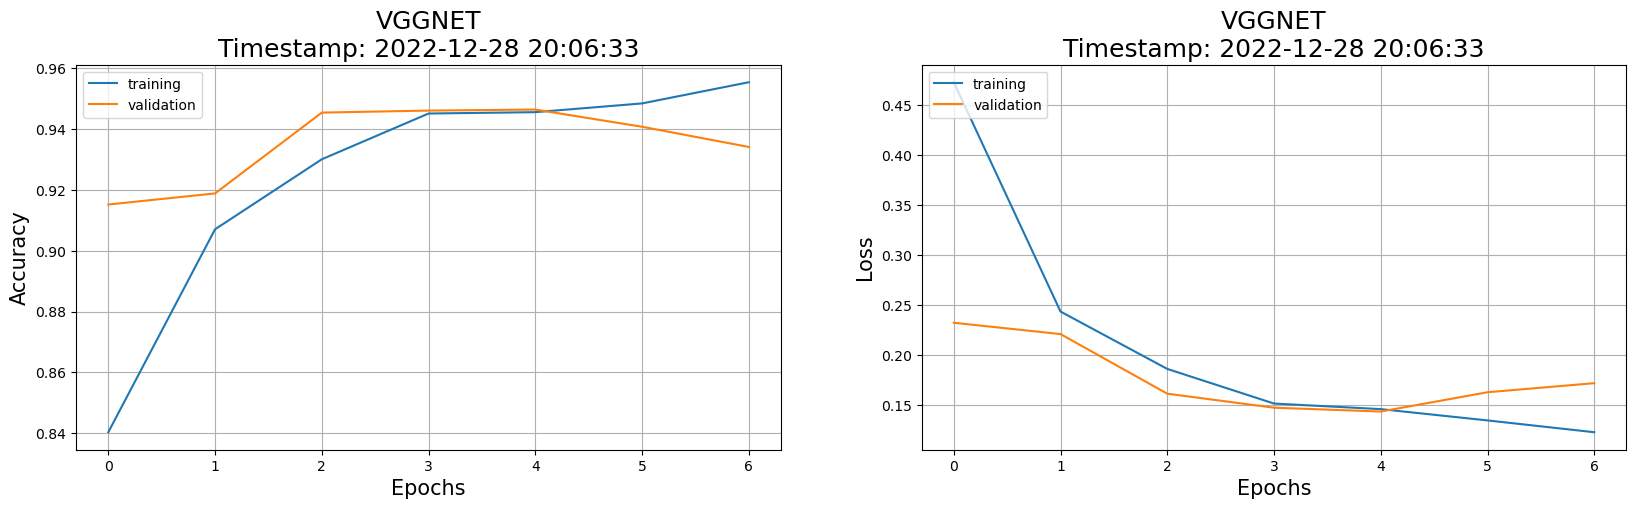

In [ ]:
performance_plot(history = vhistory, name = 'VGGNET')